In [11]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import utils, models
import argparse

plot_folder='../plots'
num_dim=2
num_epoch = 10
lr = 1e-3

In [13]:
utils.SetStyle()
tf.random.set_seed(1234)

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 2D Gaussians

Generate training & validation samples (2D Gaussians):

In [15]:
train_b, train_s, train_cdf_b, train_cdf_s, train_tanh_b, train_tanh_s = utils.DataGenerator(num_dim=num_dim)
val_b, val_s, val_cdf_b, val_cdf_s, val_tanh_b, val_tanh_s = utils.DataGenerator(num_dim=num_dim)

ValueError: Only callable can be used as callback

Plot the input distributions:

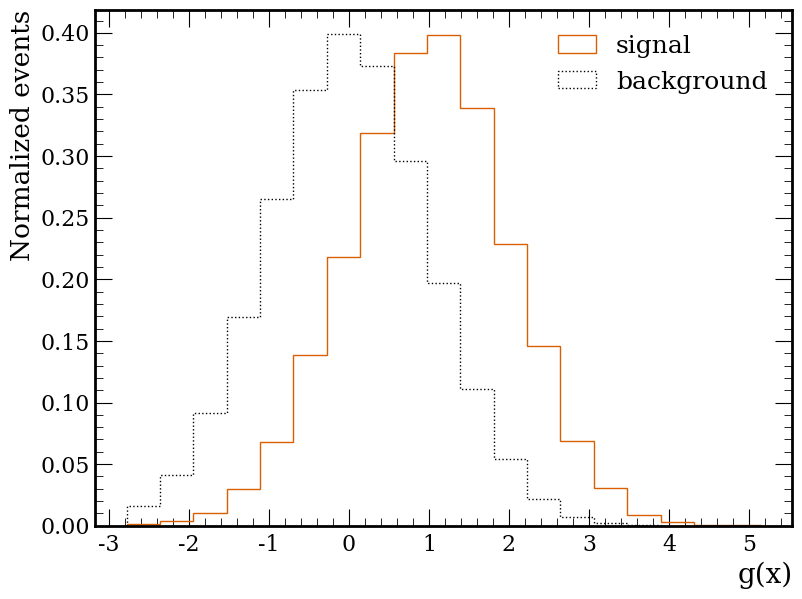

In [6]:
feed_dict={
    'signal':val_s[:,0],
    'background':val_b[:,0],
}

fig,ax = utils.HistRoutine(feed_dict,plot_ratio=False,
                           xlabel='g(x)',
                           ylabel='Normalized events',
                           reference_name='signal')


fig.savefig('{}/{}.pdf'.format(plot_folder,"Hist1D_gauss"))

Train the normalizing flow model (FFJORD) on the different transformations of the input data:

In [7]:
tf.print(tf.__version__)

2.6.0


2022-11-10 12:24:10.088048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 12:24:11.171574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39763 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [8]:
models.FFJORD(train_b,'checkpoint_Flow_gaus',
              lr=lr,max_epoch = num_epoch)

2022-11-10 12:24:11.400972: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-10 12:24:11.447094: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2022-11-10 12:24:31.721116: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 24s 441ms/step - loss: 2.9409 - val_loss: 2.8748
Epoch 2/10
8/8 [==============================] - 2s 205ms/step - loss: 2.8732 - val_loss: 2.8587
Epoch 3/10
8/8 [==============================] - 2s 204ms/step - loss: 2.8550 - val_loss: 2.8663
Epoch 4/10
8/8 [==============================] - 2s 217ms/step - loss: 2.8482 - val_loss: 2.8568
Epoch 5/10
8/8 [==============================] - 2s 205ms/step - loss: 2.8469 - val_loss: 2.8359
Epoch 6/10
8/8 [==============================] - 2s 205ms/step - loss: 2.8442 - val_loss: 2.8490
Epoch 7/10
8/8 [==============================] - 2s 209ms/step - loss: 2.8467 - val_loss: 2.8432
Epoch 8/10
8/8 [==============================] - 2s 202ms/step - loss: 2.8409 - val_loss: 2.8484
Epoch 9/10
8/8 [==============================] - 2s 210ms/step - loss: 2.8465 - val_loss: 2.8535
Epoch 10/10
8/8 [==============================] - 2s 201ms/step - loss: 2.8411 - val_loss: 2.8518
Epoch 1/10
8/8 [=============

Calculate ROC curves:

In [9]:
roc_curves = {}

fpr_gaus, tpr_gaus= models.FFJORD([],'checkpoint_Flow_gaus',[val_s,val_b],load=True)
roc_curves['Gaussian NF'] = [fpr_gaus, tpr_gaus]
#fpr_cdf, tpr_cdf= models.FFJORD([],'checkpoint_Flow_cdf',[val_cdf_s,val_cdf_b],load=True)
#roc_curves['CDF NF'] =[fpr_cdf, tpr_cdf]
#fpr_tanh, tpr_tanh= models.FFJORD([],'checkpoint_Flow_tanh',[val_tanh_s,val_tanh_b],load=True)
#roc_curves['tanh NF'] =[fpr_tanh, tpr_tanh]

KeyError: 'pop from an empty set'

Make plot of ROC curves:

In [ ]:
x = np.linspace(0,1,1000)

fig,gs = utils.SetFig("True positive rate","1 - Fake Rate") 
for plot in roc_curves:
    fpr,tpr = roc_curves[plot]
    plt.plot(tpr,1-fpr,label="{}".format(plot),
             color=utils.colors[plot],linestyle=utils.line_style[plot])
plt.plot(x,1-x,color='black',linestyle='-')
    
plt.ylim([-0.25, 1.1])
plt.legend(frameon=False,fontsize=12,ncol=3)
fig.savefig('{}/{}.png'.format(plot_folder,"ROC_gaus"))

# Physics data

https://zenodo.org/record/3548091#.Yr9ws-zMJhE

In [ ]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")
data = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

In [ ]:
mc.files

In [ ]:
mc['gen_jets'].shape

In [ ]:
mc_jet_pt_gen =  mc['gen_jets'][:,0]
mc_jet_eta_gen = mc['gen_jets'][:,1]
mc_jet_phi_gen = mc['gen_jets'][:,2]
mc_jet_m_gen =   mc['gen_jets'][:,3]

mc_jet_pt_sim =  mc['sim_jets'][:,0]
mc_jet_eta_sim = mc['sim_jets'][:,1]
mc_jet_phi_sim = mc['sim_jets'][:,2]
mc_jet_m_sim =   mc['sim_jets'][:,3]

In [ ]:
plt.figure(dpi=100, figsize=(6,4))
bins = np.linspace(0,1000,100)
plt.hist(mc_jet_pt_gen, bins=bins, alpha=0.5, label="Particle-Level");
plt.hist(mc_jet_pt_sim, bins=bins, alpha=0.5, label="Detector-Level");
plt.legend();
plt.xlabel(r'Jet $p_T$ [GeV]');
plt.ylabel('Counts');

In [ ]:
feed_dict={
    'signal':mc_jet_pt_gen,
    'background':mc_jet_pt_sim,
}

fig,ax = utils.HistRoutine(feed_dict,plot_ratio=False,
                           xlabel='g(x)',
                           ylabel='Normalized events',
                           reference_name='signal')


fig.savefig('{}/{}.pdf'.format(plot_folder,"Hist1D_physics"))

In [ ]:
phys_data_gen = np.vstack([mc_jet_phi_gen, mc_jet_eta_gen]).T
phys_data_sim = np.vstack([mc_jet_phi_sim, mc_jet_eta_sim]).T

In [ ]:
models.FFJORD(phys_data_gen,'checkpoint_Flow_physics',
              ndim=2,
              lr=lr,
              max_epoch = 100)

In [ ]:
roc_curves = {}

fpr_phys, tpr_phys = models.FFJORD([],'checkpoint_Flow_physics',[phys_data_gen, phys_data_sim],load=True)
roc_curves['Physics NF'] = [fpr_phys, tpr_phys]

In [ ]:
x = np.linspace(0,1,1000)

fig,gs = utils.SetFig("True positive rate","1 - Fake Rate") 
for plot in roc_curves:
    fpr,tpr = roc_curves[plot]
    plt.plot(tpr,1-fpr,label="{}".format(plot),
             color='magenta',linestyle='-')
plt.plot(x,1-x,color='black',linestyle='-')
    
plt.ylim([-0.25, 1.1])
plt.legend(frameon=False,fontsize=12,ncol=3)
fig.savefig('{}/{}.png'.format(plot_folder,"ROC_phys"))